In [1]:
import pandas as pd 
import numpy as np
from numpy import asarray
from pathlib import Path
import cv2, pickle, csv, os, sys, re
from PIL import Image, ImageOps
from tools import *
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.layers import Dropout, Flatten

In [11]:
# Чтение таблицы ключевых точек и директории изображении. Указать путь к CSV файлу и изображениям.
csv_file_path = Path(r"C:\Users\Sony\Desktop\University\Programs\test\test_dataset.csv")
images_dirname = Path(r"C:\Users\Sony\Desktop\University\Programs\test\colored")

# Получения основных данных 
SHAPE, last_image_index, curr_img_count, current_wd, keypoints_df, sorted_images, images_count_initail_state, csv_initial_state = get_main_data(csv_file_path, images_dirname, True)

In [12]:
# Проверка. Просмотр заглавления
keypoints_df.head()

,index,image_name,head_x,head_y,tail_x,tail_y,spine_x,spine_y,front_leg_x,front_leg_y,back_leg_x,back_leg_y
0,0,cow0.jpg,182,37,48,60,119,43,123,172,65,169
1,1,cow1.jpg,59,20,253,32,159,25,103,173,237,175
2,2,cow2.jpg,61,32,241,42,160,28,126,185,247,178
3,3,cow3.jpg,216,31,43,62,106,42,112,195,55,196
4,4,cow4.jpg,199,55,80,72,138,65,156,172,83,166


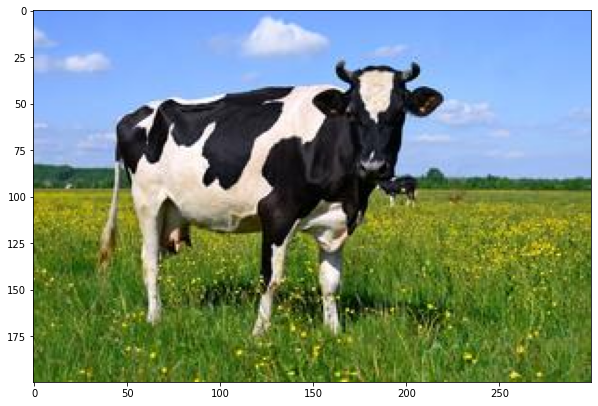

In [13]:
# Просмотр одного изображения по номеру(индексу)         
plot_cow(Path(os.path.join(images_dirname, sorted_images[0])))

In [ ]:
# Просмотр изображении с аннотациями по номеру.
show_cowannot(7, keypoints_df, images_dirname, sorted_images)

In [ ]:
#                             !!! АУГМЕНТАЦИЯ ДАННЫХ !!!

In [16]:
# Каскад увеличения данных 
data_augment = [
#     FlipImages(),
#     MirrorImages(),
#     MirrorFlipImages(),  
#     RotateImages(-15),
#     RotateImages(90),
#     
#     
#     BlurImages(10), 
#     NoiseImages(0.3), 
#     BrightenImages(1.5), 
#     ContrastImages(1.5),
#     SaturationImages(1.5),
]
AugmentApply(data_augment, SHAPE, last_image_index, curr_img_count, current_wd, keypoints_df, sorted_images, images_dirname, csv_file_path, images_count_initail_state, csv_initial_state)

Check
Применение переворота изображении
Применение отзеркаливания изображении
Применение отзеркаливания + переворота изображении
Применение вращения изображении на -15 градусов
Количество потерянных точек при вращении изображении на -15 градусов: 4 Все равно применить? [Да/Нет]да
Применение вращения изображении на 90 градусов
Количество потерянных точек при вращении изображении на 90 градусов: 7 Все равно применить? [Да/Нет]нет
Применение размытия изображении на 10
Произошла ошибка. Восстановление исходных данных...
OpenCV(4.5.2) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-_8k9tw8n\opencv\modules\imgproc\src\smooth.dispatch.cpp:294: error: (-215:Assertion failed) ksize.width > 0 && ksize.width % 2 == 1 && ksize.height > 0 && ksize.height % 2 == 1 in function 'cv::createGaussianKernels'



In [5]:
# Получения основных данных
SHAPE, last_image_index, curr_img_count, current_wd, keypoints_df, sorted_images = get_main_data(csv_file_path, images_dirname, False)

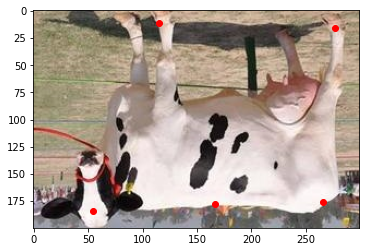

In [9]:
# Просмотр изображении с аннотациями по номеру.
show_cowannot(18, keypoints_df, images_dirname, sorted_images)

In [ ]:
#                            !!! ЧАСТЬ МАШИННОГО ОБУЧЕНИЯ !!!

In [ ]:
# Подготовка данных
if SHAPE[2] == 3:
    X = np.stack([string2image(Path(os.path.join(images_dirname, image_path))) for image_path in sorted_images]).astype(np.float64)[:, :, :, :]
if SHAPE[2] == 1:
    X = np.stack([string2image(Path(os.path.join(images_dirname, image_path))) for image_path in sorted_images]).astype(np.float64)[:, :, :, np.newaxis]

y = np.vstack(keypoints_df[keypoints_df.columns[2:]].values)
X_train = X / 255

In [ ]:
# Подготовка данных
output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(y)

In [ ]:
# МОДЕЛЬ МАШИННОГО ОБУЧЕНИЯ
model = Sequential()

# Входной слой
model.add(BatchNormalization(input_shape=(SHAPE)))
model.add(Conv2D(360, (5, 5), kernel_initializer='random_normal'))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add(Dropout(0.2))

# Второй слой
model.add(Conv2D(480, (5, 5)))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add(Dropout(0.2))

# Третий слой
model.add(Conv2D(640, (5, 5)))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add(Dropout(0.2))

# Четвертый слой
model.add(Conv2D(720, (3, 3)))
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add(Dropout(0.2))

# Пятый слой
model.add(Conv2D(720, (3, 3)))
model.add(Activation('sigmoid'))
model.add(Flatten())

# Шестой слой
model.add(Dense(5000, activation="sigmoid"))

# Седьмой слой
model.add(Dense(800, activation="sigmoid"))

# Восьмой слой
model.add(Dense(y.shape[1]))

In [ ]:
# Проведение машинного обучения
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 11
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=2)

In [ ]:
# Подготовка тестовых данных
img = X_train[0, :, :, :].reshape(1, *SHAPE)
predictions = model.predict(img)

In [ ]:
# Предсказание модели
xy_predictions = output_pipe.inverse_transform(predictions).reshape(y.shape[1]//2, 2)

In [ ]:
# Проверка предсказании. Вывод данных
if SHAPE[2] == 3:
    plt.imshow(X_train[0, :, :, :])
if SHAPE[2] == 1:
    plt.imshow(X_train[0, :, :, :], cmap='gray')
plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'b*')

In [ ]:
# # Для сохранения обученной модели
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))

# # Для загрузки ранее сохраненной модели
# loaded_model = pickle.load(open(filename, 'rb'))